# Lecture 15 (4/29/2022)

**Announcements**
- Pset 4 will be released today, due next Friday 5/6

*Last time we covered:*
- Evaluating regression: $R^2$, out-of-sample prediction, parameter interpretation

**Today's agenda:**
- Polynomial regression, multiple regression


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read in and prepare the data we were using last time
mpg = sns.load_dataset('mpg')
mpg_clean = mpg.dropna().reset_index(drop = True)

mpg_clean

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino
...,...,...,...,...,...,...,...,...,...
387,27.0,4,140.0,86.0,2790,15.6,82,usa,ford mustang gl
388,44.0,4,97.0,52.0,2130,24.6,82,europe,vw pickup
389,32.0,4,135.0,84.0,2295,11.6,82,usa,dodge rampage
390,28.0,4,120.0,79.0,2625,18.6,82,usa,ford ranger


# Review: Evaluating linear regression

In last lecture, we talked about three ways of checking that your regression fit the data well. 
1. $R^2$ *coefficient of determination*
2. Out of sample prediction accuracy
3. High confidence (and useful) parameter estimates


Let's start by running through each of these in a little more detail since we didn't get much time to discuss them.

## $R^2$, the *coefficient of determination*

![determination](img/Determination.png)


$ R^2 = 1 - \dfrac{RSS}{TSS} $

$ RSS = \sum_{i=1}^{n}{(y_i - \hat{y_i})}^2 $

$ TSS = \sum_{i=1}^{n}{(y_i - \bar{y})}^2 $

$R^2$ ranges between 0 and 1 and can be thought of as the *percentage of variance in $y$ that our model explains*.

To understand how it works, remember that RSS is 0 when the regression *perfectly predicts our data* and RSS is equal to TSS when we just guess $\bar{y}$ for every data point $y_i$ (worst case for our regression).

In [3]:
# The scikit-learn LinearRegression class surfaces a function called `score` that computes R^2

from sklearn.linear_model import LinearRegression

# Format values
x_vals = np.array(mpg_clean['weight']).reshape(len(mpg_clean['weight']), 1)
y_vals = np.array(mpg_clean['horsepower'])

# Fit regression
mod = LinearRegression().fit(X = x_vals, y = y_vals)

rsq_mod = mod.score(X = x_vals, y = y_vals) # R^2 value
rsq_mod

0.74742549968982

Last time, we showed how to calculate the $R^2$ value by hand using the LinearRegression `predict` function. 

If you're feeling hazy on $R^2$, I recommend going back to the code from that lecture and going through the part where we calculate $R^2$.


***

## Out of sample prediction

![train](img/train.jpeg)


**Motivation** 

If our model is the right fit to our data, it should predict other data from the same underlying distribution or generative process pretty well.

**How to check this**

There are a lot of ways to test out of sample data which we'll get into in more detail on Monday, but the high-level approach is almost always:
1. *Randomly* select a subset of your original data (20-25%) and set it aside as *test data*. The remaining data is your *training data*.
2. Fit your model to the *training data only*. 
3. See how well your fitted model predicts the *test data*. Compare it to the predictions on the training data with something like *Mean Squared Error* (MSE). 
4. Often, repeat steps 1-3 in various ways (more on that later).

**Comparing train and test performance**

Step 3 above is critical. One common approach is to use *Mean Squared Error* (MSE):

$ MSE = \dfrac{1}{n - 2} \sum_{i=1}^{n}{(y_i - \hat{y_i})}^2 = \dfrac{1}{n - 2} \sum_{i=1}^{n}{\epsilon_i}^2 $

This tells you, on average, how close your model was to the true value across all the data points (the $n-2$ is specific to linear regression where we have two parameters, $\beta_0$ and $\beta_1$, so $n-2$ is our degrees of freedom).

In [4]:
from sklearn.model_selection import train_test_split # Use the sklearn `train_test_split` to make this easy
from sklearn.metrics import mean_squared_error # Use the sklearn `mean_squared_error` for quick MSE calculation

# Randomly sample 25% of our data points to be test data
xtrain, xtest, ytrain, ytest = train_test_split(x_vals, 
                                                y_vals, 
                                                test_size = 0.25
                                               )
# Fit the model on the training data
mod_tr = LinearRegression().fit(X = xtrain, y = ytrain)

# Generate model predictions for the test data
mod_preds_test = mod_tr.predict(X = xtest)

# Compare MSE for the model predictions on train and test data
mod_preds_train = mod_tr.predict(X = xtrain)

mse_train = mean_squared_error(y_true = ytrain, y_pred = mod_preds_train)
mse_train # Note this divides by n rather than n-2 but that's not super important for our purposes

mse_test = mean_squared_error(y_true = ytest, y_pred = mod_preds_test)
mse_test

print("Training MSE: {} \nTest MSE: {}".format(mse_train, mse_test))

Training MSE: 362.70613120726557 
Test MSE: 405.079291570969


Just for fun, try running the code above several times and look at how different the values are. 

*More on this next week...*

***

## Parameter estimates

![right](img/right.png)

The criteria above are mostly concerned with whether we're doing *a good job predicting our $y$ values* with this model.

In many cases, part of what we're concerned with isn't just how well we predict our data, but what kind of relationship our model estimates between $x$ and $y$. 
- How large or small is the slope?
- How confident are we in the estimate?

To assess this, we typically compute confidence bounds on the parameter estimates (95% confidence interval or standard error) and compare them to a null value of 0 using $t$ tests.

**Linear regression parameter estimates are most useful when they are high confidence and significantly different from 0.**

The sklearn `LinearRegression` class doesn't include functions for this sort of analysis, but other tools like the `statsmodels` regression class do.

In [5]:
import statsmodels.formula.api as smf

# Fit the model
results = smf.ols('horsepower ~ weight', data = mpg_clean).fit()

# View the results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             horsepower   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     1154.
Date:                Tue, 14 Jun 2022   Prob (F-statistic):          1.36e-118
Time:                        18:22:37   Log-Likelihood:                -1717.0
No. Observations:                 392   AIC:                             3438.
Df Residuals:                     390   BIC:                             3446.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -12.1835      3.570     -3.412      0.001     -19.203      -5.164
weight         0.0392      0.001     33.972      0.000       0.037       0.041
==============================================================================
Omnibus:                       83.255   Durbin-Watson:                   1.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              312.937
Skew:                           0.892   Prob(JB):                     1.11e-68
Kurtosis:                       6.997   Cond. No.                     1.13e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

***

# Problems with simple linear regression

![corr_ex](img/corr_ex.png)
Disclaimer: this figure (from wikipedia) shows *correlation* values associated with these datasets, but the limitations of correlation in capturing these patterns holds for linear regression as well.

## Polynomial regression: non-linear relationship between $x$ and $y$

Non-linear data can take all kinds of forms, though there are probably a few that are most common.

Let's take a look at a simple example from our cars dataset:

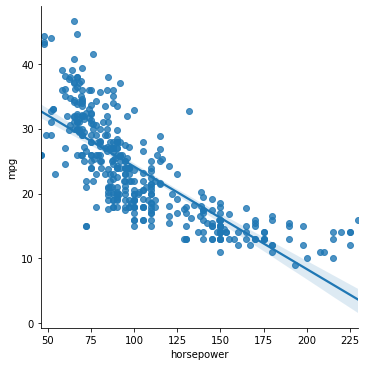

In [6]:
sns.lmplot(data = mpg_clean, x = "horsepower", y = "mpg")

Does this data have a linear relationship between $x$ and $y$? Seems like it might be more complicated.

Enter: polynomial regression!

### Polynomial regression: overview

Polynomial regression is just like linear regression except that instead of fitting a linear function to the data, we fit higher degree polynomials. 

Previously, our simple linear regression model assumed that our data $(x_i, y_i)$ could be described as:

$y_i = \beta_0 + \beta_1 x_i + \epsilon_i$

The OLS process estimates values for $\beta_0$ and $\beta_1$ that correspond to a straight line that minimizes $\epsilon_i$.

With polynomial regression, we extend this basic model to include functions of the form:

$y_i = \beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \epsilon_i$ for *degree 2* polynomial regression,

$y_i = \beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \beta_3 x_i^3 + \epsilon_i$ for *degree 3* polynomial regression, 

$y_i = \beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \beta_3 x_i^3 + \ ... \ + \beta_n x_i^n + \epsilon_i$ for *degree n* polynomial regression.

Even though this seems much more complex, polynomial regression uses the same *Ordinary Least Squares* (OLS) parameter estimation as simple regression. You can think of simple linear regression as a special case of polynomial regression. 

**This gives us immense flexibility to fit more complex functions to our data.** Some of the data illustrated at the top of this section can *only* be modeled using more complex polynomials (see example below as well).

**CAUTION**: most of the time you *don't* need polynomials to capture your data. Bad things happen when you use them for data that doesn't have an underlying non-linear structure. More on this on Monday.

![poly](img/Poly.png)

### Polynomial regression in python

We can use the numpy `polyfit` library to fit 2nd and 3rd order polynomials to this data
(Note: this is probably the simplest method, but there's code to use the familiar scikit learn approach as well below).

In [7]:
# We can fit higher order polynomial functions to our data rather than just a linear function
deg1_fits = np.polyfit(mpg_clean.horsepower, mpg_clean.mpg, 1)
deg2_fits = np.polyfit(mpg_clean.horsepower, mpg_clean.mpg, 2)
deg3_fits = np.polyfit(mpg_clean.horsepower, mpg_clean.mpg, 3)

p1 = np.poly1d(deg1_fits)
p2 = np.poly1d(deg2_fits)
p3 = np.poly1d(deg3_fits)

In [8]:
# What do the functions fitted above predict for our data?

preds = mpg_clean.loc[:, ('horsepower', 'mpg')]

preds['deg1_pred'] = p1(preds['horsepower'])
preds['deg2_pred'] = p2(preds['horsepower'])
preds['deg3_pred'] = p3(preds['horsepower'])

preds

preds_long = preds.melt(
    id_vars = ['horsepower', 'mpg']
)
preds

,horsepower,mpg,deg1_pred,deg2_pred,deg3_pred
0,130.0,18.0,19.416046,17.091508,17.153421
1,165.0,15.0,13.891480,13.480156,13.782683
2,150.0,18.0,16.259151,14.658717,14.890157
3,150.0,16.0,16.259151,14.658717,14.890157
4,140.0,17.0,17.837598,15.752059,15.904046
...,...,...,...,...,...
387,86.0,27.0,26.361214,25.908837,25.774667
388,52.0,44.0,31.727935,35.985609,36.424392
389,84.0,32.0,26.676903,26.422834,26.298564
390,79.0,28.0,27.466127,27.750895,27.662364


<AxesSubplot:xlabel='horsepower', ylabel='mpg'>

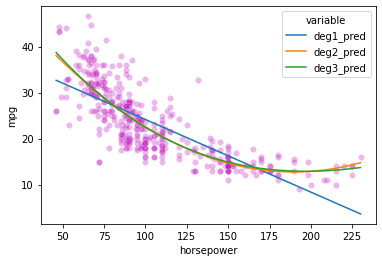

In [9]:
# First, our original data
sns.scatterplot(data = preds_long,
                x = 'horsepower',
                y = 'mpg',
                color = 'm',
                alpha = 0.1
               )

# Now add in our lines
sns.lineplot(data = preds_long,
             x = 'horsepower',
             y = 'value',
             hue = 'variable'
            )

Here's the solution using scikit learn; it's a bit more complicated, though it does let you keep using the `LinearRegression` class 

In [10]:
from sklearn.preprocessing import PolynomialFeatures

x_vals = np.array(mpg_clean['horsepower']).reshape(len(mpg_clean['horsepower']), 1)
y_vals = np.array(mpg_clean['mpg'])
preds = mpg_clean.loc[:, ('horsepower', 'mpg')]

# Simple linear model
mod1 = LinearRegression().fit(x_vals, y_vals)

# 2nd order polynomial
poly2 = PolynomialFeatures(degree = 2, include_bias = False)
x2_features = poly2.fit_transform(x_vals)
mod2 = LinearRegression().fit(x2_features, y_vals)


# 3rd order polynomial
poly3 = PolynomialFeatures(degree = 3, include_bias = False)
x3_features = poly3.fit_transform(x_vals)
mod3 = LinearRegression().fit(x3_features, y_vals)


mod2.coef_
# mod3.coef_

array([-0.46618963,  0.00123054])

In [11]:
# Add predictions for each model so we can view how it does
preds['deg1_pred'] = mod1.predict(x_vals)
preds['deg2_pred'] = mod2.predict(x2_features)
preds['deg3_pred'] = mod3.predict(x3_features)

preds


,horsepower,mpg,deg1_pred,deg2_pred,deg3_pred
0,130.0,18.0,19.416046,17.091508,17.153421
1,165.0,15.0,13.891480,13.480156,13.782683
2,150.0,18.0,16.259151,14.658717,14.890157
3,150.0,16.0,16.259151,14.658717,14.890157
4,140.0,17.0,17.837598,15.752059,15.904046
...,...,...,...,...,...
387,86.0,27.0,26.361214,25.908837,25.774667
388,52.0,44.0,31.727935,35.985609,36.424392
389,84.0,32.0,26.676903,26.422834,26.298564
390,79.0,28.0,27.466127,27.750895,27.662364


<AxesSubplot:xlabel='horsepower', ylabel='mpg'>

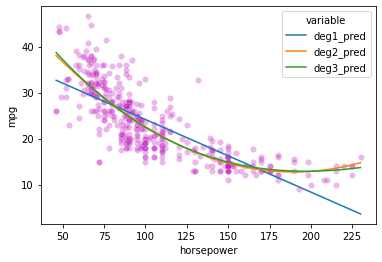

In [12]:
preds_long = preds.melt(
    id_vars = ['horsepower', 'mpg']
)
preds

# First, our original data
sns.scatterplot(data = preds_long,
                x = 'horsepower',
                y = 'mpg',
                color = 'm',
                alpha = 0.1
               )

# Now add in our lines
sns.lineplot(data = preds_long,
             x = 'horsepower',
             y = 'value',
             hue = 'variable'
            )

In [13]:
# Let's check the R^2 values for these models to see what kind of improvement we get
# (more on this next week)



***

## Multiple regression: multiple predictors for $y$

Another basic scenario that arises when predicting a continuous variable (probably more commonly than polynomial regression) is having *multiple predictors*.

Let's take a look at an intuitive example:

In [14]:
gap = pd.read_csv("https://raw.githubusercontent.com/UCSD-CSS-002/ucsd-css-002.github.io/master/datasets/gapminder.csv")

# Let's keep just some of the variables (note for pset!)
gap_subset = gap.loc[gap['year'] == 2007, ('country', 'year', 'lifeExp', 'pop', 'gdpPercap')]

# Add log population
gap_subset['logPop'] = np.log10(gap_subset['pop'])
gap_subset['logGdpPercap'] = np.log10(gap_subset['gdpPercap'])
gap_subset



,country,year,lifeExp,pop,gdpPercap,logPop,logGdpPercap
11,Afghanistan,2007,43.828,31889923,974.580338,7.503653,2.988818
23,Albania,2007,76.423,3600523,5937.029526,6.556366,3.773569
35,Algeria,2007,72.301,33333216,6223.367465,7.522877,3.794025
47,Angola,2007,42.731,12420476,4797.231267,7.094138,3.680991
59,Argentina,2007,75.320,40301927,12779.379640,7.605326,4.106510
...,...,...,...,...,...,...,...
1655,Vietnam,2007,74.249,85262356,2441.576404,7.930757,3.387670
1667,West Bank and Gaza,2007,73.422,4018332,3025.349798,6.604046,3.480776
1679,"Yemen, Rep.",2007,62.698,22211743,2280.769906,7.346583,3.358081
1691,Zambia,2007,42.384,11746035,1271.211593,7.069891,3.104218


In the last problem set, you generated a graph that predicted life expectancy as a function of income, with information about population and region available as well. 

![gap](img/gapminder.png)

The graph suggests that life expectancy is strongly predicted by income, while population may not play such an important role. 

Let's test that here!

What that amounts to asking is:

**Can we predict life expectancy using both income *and* population better than we could only using one of those variables?**

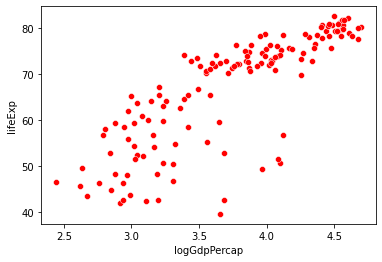

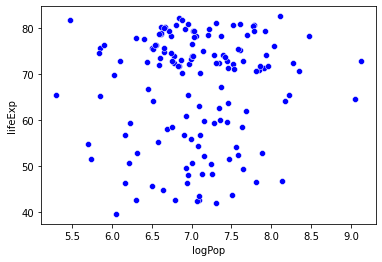

In [15]:
sns.scatterplot(data = gap_subset, 
                x = "logGdpPercap", # x1 
                y = "lifeExp",
                color = "r"
               )
plt.show()

sns.scatterplot(data = gap_subset, 
                x = "logPop", # x2 
                y = "lifeExp",
                color = "b"
               )
plt.show()

### Multiple regression: overview

Multiple regression is like linear regression except that we assume our dependent variable $y_i$ is *jointly* predicted by multiple independent variables $x_1$, $x_2$, ..., $x_n$, as in the example above.

As noted above, our simple linear regression model assumes that our data $(x_i, y_i)$ has the following form:

$y_i = \beta_0 + \beta_1 x_i + \epsilon_i$

With multiple regression, we now extend this model to include multiple predictors:

$y_i = \beta_0 + \beta_1 x_{i,1} + \beta_2 x_{i,2} + \ ... \ + \beta_n x_{i,n} + \epsilon_i $

In most cases, multiple regression once again uses the same *Ordinary Least Squares* (OLS) parameter estimation as simple regression. However, interpreting the parameter estimates is a little less straightforward.

*How would we interpret $\beta_0 = 1$, $\beta_1 = 2$, $\beta_2 = 3$*?

### Multiple regression in python

To run our multiple regression, we can use the scikit `LinearRegression` class with just a few modifications to our simple regression code.

I've also included the statsmodels code below as well so we can look at the statistics more closely!

In [16]:
# scikit learn approach
x_vals = np.array(gap_subset[['logGdpPercap', 'logPop']]) # Note: this syntax is important!
x_vals = x_vals.reshape(len(gap_subset), 2)
x_vals

y_vals = np.array(gap_subset['lifeExp'])
y_vals

mod = LinearRegression().fit(X = x_vals, y = y_vals)

mod.intercept_
mod.coef_

array([16.6811828 ,  1.86827925])

In [17]:
# How well does our regression do?
mod.score(X = x_vals, y = y_vals)

0.6649393884784984

Using the statsmodels regression class, we can view statistical tests on our parameter fits

In [18]:
multiple_reg = smf.ols('lifeExp ~ logGdpPercap + logPop', data = gap_subset).fit()

# View the results
multiple_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lifeExp   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     137.9
Date:                Tue, 14 Jun 2022   Prob (F-statistic):           9.91e-34
Time:                        18:22:45   Log-Likelihood:                -477.07
No. Observations:                 142   AIC:                             960.1
Df Residuals:                     139   BIC:                             969.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -8.6161      7.538     -1.143      0.255     -23.520       6.288
logGdpPercap    16.6812      1.008     16.555      0.000      14.689      18.673
logPop           1.8683      0.896      2.086      0.039       0.098       3.639
==============================================================================
Omnibus:                       34.155   Durbin-Watson:                   2.170
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.987
Skew:                          -1.183   Prob(JB):                     1.15e-12
Kurtosis:                       4.923   Cond. No.                         104.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""